In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(img_batch[0])

(32, 256, 256, 3)
[1 0 0 1 0 1 1 1 0 2 0 0 0 0 1 2 1 1 1 1 0 0 0 2 1 1 1 1 1 0 0 0]
tf.Tensor(
[[[115. 105. 116.]
  [118. 108. 119.]
  [110. 100. 111.]
  ...
  [155. 148. 156.]
  [155. 148. 156.]
  [156. 149. 157.]]

 [[117. 107. 118.]
  [121. 111. 122.]
  [114. 104. 115.]
  ...
  [157. 150. 158.]
  [157. 150. 158.]
  [158. 151. 159.]]

 [[111. 101. 112.]
  [116. 106. 117.]
  [112. 102. 113.]
  ...
  [158. 151. 159.]
  [159. 152. 160.]
  [160. 153. 161.]]

 ...

 [[113. 105. 118.]
  [104.  96. 109.]
  [ 95.  87. 100.]
  ...
  [154. 146. 157.]
  [156. 148. 159.]
  [159. 151. 162.]]

 [[107.  99. 112.]
  [ 98.  90. 103.]
  [ 93.  85.  98.]
  ...
  [155. 147. 158.]
  [157. 149. 160.]
  [159. 151. 162.]]

 [[114. 106. 119.]
  [108. 100. 113.]
  [110. 102. 115.]
  ...
  [164. 156. 167.]
  [162. 154. 165.]
  [160. 152. 163.]]], shape=(256, 256, 3), dtype=float32)


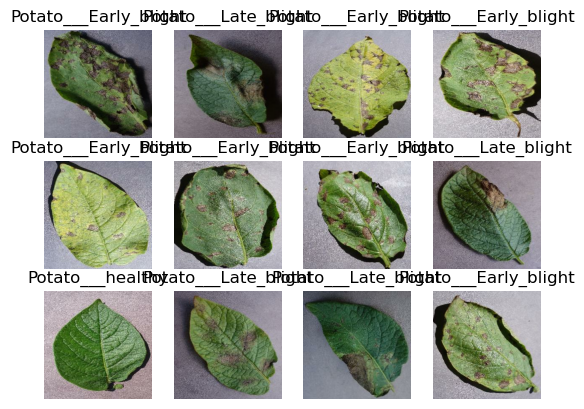

In [8]:
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#  in this we divide the dataset into training, validation and test
#  in the ratio of 80:10:10

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [22]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
CHANNELS = 3 
BATCH_SIZE = 32

model = models.Sequential([
#     layers.InputLayer(input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_and_rescale, 
    data_augmentaion, 
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), 
    layers.Dense(3, activation = 'softmax')
])

model.build(input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [35]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1, 
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9767 - loss: 0.0720 - val_accuracy: 0.9688 - val_loss: 0.0750
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9777 - loss: 0.0606 - val_accuracy: 0.9792 - val_loss: 0.0596
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9779 - loss: 0.0638 - val_accuracy: 0.9740 - val_loss: 0.0747
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9772 - loss: 0.0650 - val_accuracy: 0.9844 - val_loss: 0.0373
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9746 - loss: 0.0651 - val_accuracy: 0.8906 - val_loss: 0.4230
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9762 - loss: 0.0672 - val_accuracy: 0.9740 - val_loss: 0.0598
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9688 - loss: 0.0813 - val_accuracy: 0.9167 - val_loss: 0.2608
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9766 - loss: 0.0592 - val_accuracy: 0.9635 - val_loss:

In [37]:
score = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.9312 - loss: 0.1856


In [38]:
score

[0.1746269166469574, 0.93359375]

In [39]:
history

In [40]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [41]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'training and validation loss')

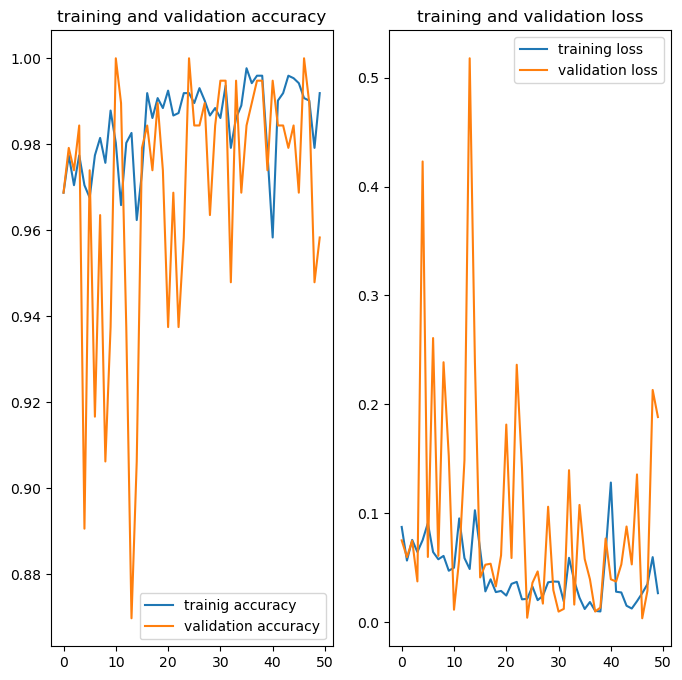

In [43]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'trainig accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'training loss')
plt.plot(range(EPOCHS), val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('training and validation loss')

first img to predict
actual label : Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
predicted label : Potato___Early_blight


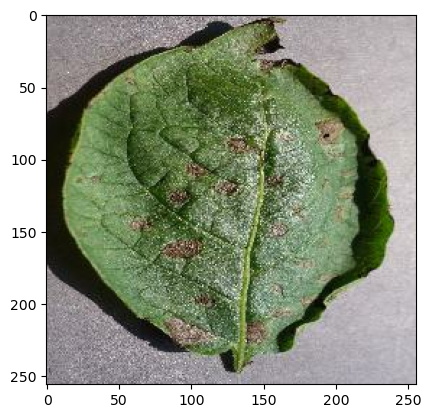

In [44]:
for image_batch, labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first img to predict')
    plt.imshow(first_img)
    print('actual label :', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label :', class_names[np.argmax(batch_prediction[0])])

In [45]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(img[i])
#     img_array = tf.expand_dims(img_array, 0)  #create a batch
    
#     img_rgb = tf.image.grayscale_to_rgb(img[i])
#     predictions = model.predict(tf.expand_dims(img_rgb,0))
    
#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 *(np.max(predictions[0])), 2)
#     return predicted_class, confidence

In [47]:
def predict(model, img):
    # Ensure the image has 3 channels (RGB)
    if img.shape[-1] == 1:
        img = tf.image.grayscale_to_rgb(img)

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


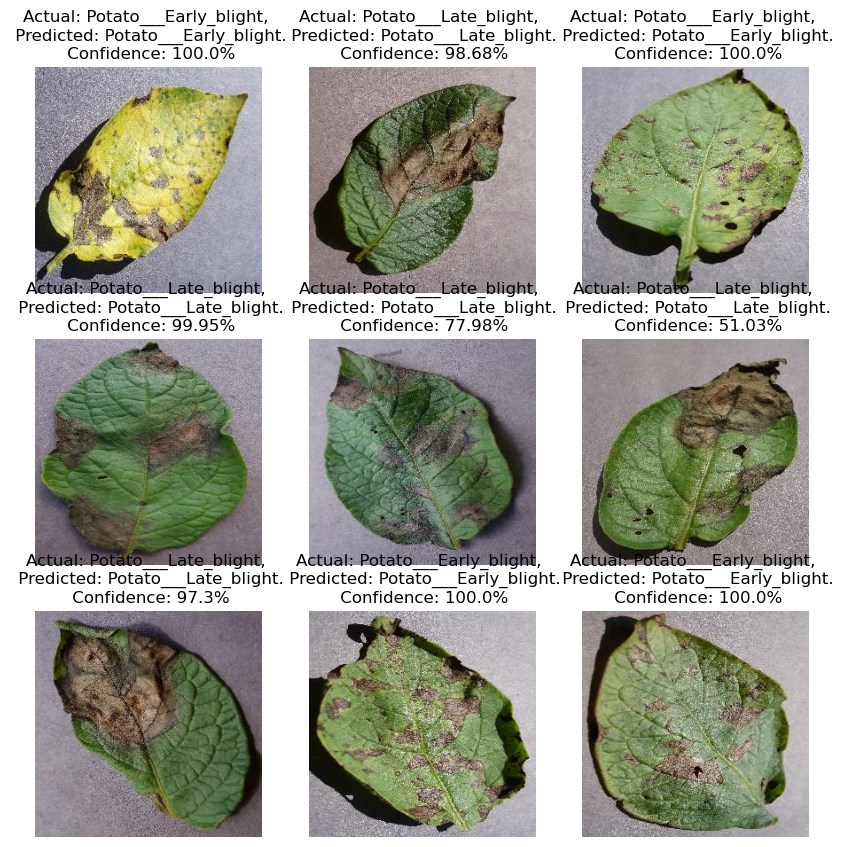

In [50]:
plt.figure(figsize=(10,10))
for img, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i + 1)
        plt.imshow(img[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, img[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [60]:
model_version = 2
# model.save(f"C:\\Users\\ASUS\\Deep learning\\Project\\plant_disease_classification\\models\\{model_version}")
model.save(f"./models/{model_version}.keras")